# Diabetes in 130 US hospitals for the years 1999 to 2008

This notebook accomplishes the analysis on the diabetes data set by adopting some of the practices outlined in Chapter 2 of Aurélien Géron's book _Hands-on Machine Learning with Scikit-Learn, Keras, and TensorFlow_ (with the [link to his GitHub here](https://github.com/ageron/handson-ml)). Its primary motivation is to be a template for future machine learning analysis by making use of specific, dedicated classes available from `scikit-learn` for numerical and categorical data preparation.

 - [Summary of data preparation](#Summary-of-data-preparation)
 - [Data cleaning](#Data-cleaning)
 - [Handling numerical and categorical features with pipelines](#Handling-numerical-and-categorical-features-with-pipelines)
   - [Transformation pipeline](#Transformation-pipeline)

# Summary of data preparation

This part is taken verbatim from the first notebook except for only including the results of the exploratory data analysis section.

 - All of the `object` values in the data frame, which are text values in the CSV file, are converted to categorical values.
 - After reviewing the results in the `Exploratory data analysis` section, we remove: 
   - all `NaN` values from the data, and the `Unknown/Invalid` subcategory from the `Gender` category,
   - `weight`, `medical_specialty` and `payer_code` columns due to the large presence of `NaN` values,
   - `encounter_id` column since it isn't relevant to the analysis,
   - duplicate patient data to maintain the statistical independence of the data which is required by logistic regression, after which the `patient_nbr` column is dropped.
   - `admission_type_id`, `discharge_disposition_id` and `admission_source_id` columns, since they don't have any bearing on readmission,
- `diag_1`, `diag_2` and `diag_3` values are encoded into nine major groups: `circulatory`, `respiratory`, `digestive`, `diabetes`, `injury`, `musculoskeletal`, `genitourinary`, `neoplasms` and `others`.
 - `readmitted` column is divided into two `0` and `1` categories, where the `1` category groups the two `< 30 days` and `> 30 days` cases together,
 - Feature scaling is preformed on all numerical values using the `sklearn.preprocessing.StandardScaler` class.
 - Dummy variables are created for all categorical columns using the `sklearn.preprocessing.OneHotEncoder` class.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)

In [3]:
df = pd.read_csv('data/diabetic_data.csv', na_values='?', low_memory=False)
obj_cols = df.select_dtypes('object').columns
df[obj_cols] = df[obj_cols].astype('category')

In [4]:
df.shape

(101766, 50)

# Data cleaning

We're removing null values for race and `Unknown/Invalid` values for gender.

In [5]:
df = df.loc[df.race.notnull()]
df = df.loc[df.gender != 'Unknown/Invalid', :]

As stated above, we remove `weight`, `medical_specialty` and `payer_code` due to the large presence of `NaN` values. We also remove `encounter_id` since it isn't relevant to our analysis.

In [6]:
df.drop(['weight', 'medical_specialty', 'payer_code', 'encounter_id'], axis=1, inplace=True)

We discard the `admission_type_id`, `discharge_disposition_id` and `admission_source_id` columns since they don't have any bearing on readmission.

In [7]:
df.drop(['admission_type_id' ,'discharge_disposition_id', 'admission_source_id'], axis=1, inplace=True)

Now we will discard all rows that contains `NaN` values.

In [8]:
df.dropna(how='any', inplace=True)

In [9]:
df.shape

(98052, 43)

According to the [analysis conditions laid out in the research article](https://www.hindawi.com/journals/bmri/2014/781670/), the duplicate patient data were removed to maintain the statistical independence of the data, which is a condition required by logistic regression. Once this is computed, the `patient_nbr` column can be dropped.

In [10]:
df.drop_duplicates(['patient_nbr'], inplace=True)
df.drop(['patient_nbr'], axis=1, inplace=True)

In [11]:
df.shape

(68629, 42)

## Grouping primary, secondary and additional diagnosis values into group categories

Column values for the primary, secondary and additional diagnoses, `diag_1`, `diag_2` and `diag_3`, are encoded in over 700 individual code entries of which the first three digits are listed in each entry. Following the grouping in Table 2 of the articlefor the primary diagnosis, we can reduce these values to nine major groups, which are `Circulatory`, `Respiratory`, `Digestive`, `Diabetes`, `Injury`, `Musculoskeletal`, `Genitourinary`, `Neoplasms` and `Others`. We do this for the secondary and addtional diagnoses as well.

In [12]:
circulatory_list = [str(f) for f in list(range(390, 460)) + [785]]
respiratory_list = [str(f) for f in list(range(460, 520)) + [786]]
digestive_list = [str(f) for f in list(range(520, 580)) + [787]]
injury_list = [str(f) for f in list(range(800, 1000))]
musculoskeletal_list = [str(f) for f in list(range(710, 740))]
genitourinary_list = [str(f) for f in list(range(580, 630)) + [788]]
neoplasms_list = [str(f) for f in list(range(140, 240))]

In [13]:
diagnosis_list = [circulatory_list, respiratory_list, digestive_list, injury_list, musculoskeletal_list, \
genitourinary_list, neoplasms_list]
diagnosis_names = ['Circulatory', 'Respiratory', 'Digestive', 'Injury', 'Musculoskeletal', 'Genitourinary', \
                   'Neoplasms']
diag_columns = ['diag_1', 'diag_2', 'diag_3']

In [14]:
for index, diag_col in enumerate(diag_columns):
    for diag_name, diag_list in zip(diagnosis_names, diagnosis_list):
        df.loc[:, diag_name+'_'+str(index)+'_col'] = np.array([np.nan for i in range(df.shape[0])])
        filter_ = df[diag_col].isin(diag_list)
        df.loc[filter_, diag_name+'_'+str(index)+'_col'] = np.array([diag_name for i in range(filter_.sum())])

In [15]:
df.shape

(68629, 63)

In [16]:
diab_others_list = ['Diabetes', 'Others', 'Others']
char_list = ['250.', 'E', 'V']

In [17]:
for index, diag_col in enumerate(diag_columns):
    for diag_name, char in zip(diab_others_list, char_list):
        df.loc[:, diag_name+'_'+str(index)+'_col'] = np.array([np.nan for i in range(df.shape[0])])
        filter_ = df[diag_col].str.contains(char)
        df.loc[filter_, diag_name+'_'+str(index)+'_col'] = np.array([diag_name for i in range(filter_.sum())])

In [18]:
df.shape

(68629, 69)

The primary (`diag_1`), secondary (`diag_2`) and additional diagnoses (`diag_3`) are dropped.

In [19]:
df.drop(diag_columns, axis=1, inplace=True)

In [20]:
df.shape

(68629, 66)

In [21]:
final_diag_list = ['primary_diag', 'secondary_diag', 'additional_diag']
for index, diag in enumerate(final_diag_list):
    tmp_diag_list = [col+'_'+str(index)+'_col' for col in diagnosis_names + ['Diabetes', 'Others']]
    df[diag] = df[tmp_diag_list].fillna(axis=1, method='bfill').iloc[:, 0]
    df[diag].fillna(value='Others', inplace=True)
    df[diag] = df[diag].astype('category')
    df.drop(tmp_diag_list, axis=1, inplace=True)

In [22]:
diagnosis_df = df['primary_diag'].value_counts(dropna=False)
diagnosis_df.sort_values(ascending=False, inplace=True)
diagnosis_df = (diagnosis_df/diagnosis_df.sum()*100).apply('{:.2f}'.format).astype('float')
diagnosis_df = diagnosis_df.reset_index().rename(columns={'index': 'Primary diagnosis', 'primary_diag': 'Percentage'})

In [23]:
order_list = ['Circulatory', 'Respiratory', 'Digestive', 'Diabetes', 'Injury', 'Musculoskeletal', \
              'Genitourinary', 'Neoplasms', 'Others']
diagnosis_df = diagnosis_df.set_index('Primary diagnosis').loc[order_list]
diagnosis_sr = pd.Series(diagnosis_df.Percentage, index=diagnosis_df.index)

Using the primary diagnosis (`diag_1`) category, the `Circulatory` category tends to be overly represented with respect to all the other categories, even with the `Others` category containing all of the remaining categories that are present at or lower than 3.5% (which regard about 17.0% of the total data in our analysis).

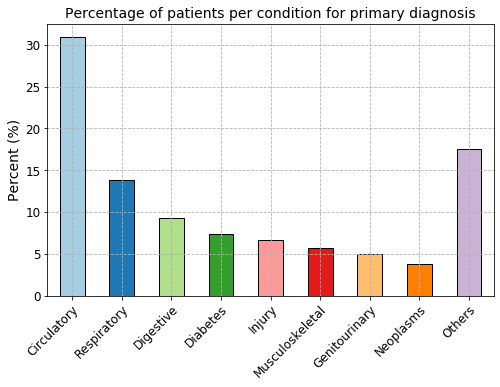

In [24]:
ax = diagnosis_sr.plot(kind='bar', color=plt.cm.Paired.colors, figsize=(8, 5), edgecolor='k')
plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor", rotation=45, fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)
ax.set_xlabel(None)
ax.set_ylabel('Percent (%)', fontsize=14)
ax.set_title('Percentage of patients per condition for primary diagnosis', fontsize=14)
plt.grid(True, linestyle='--');

## Grouping `>30 days` and `<30 days ` into the `Yes` category in the `readmitted` column

We're grouping together the `>30` and `<30` categories into the `YES` category.

In [25]:
df['readmitted'].replace(['>30', '<30'], '1', inplace=True)
df['readmitted'].replace(['NO'], '0', inplace=True)
df['readmitted'] = df['readmitted'].astype('int64')

We're resetting the index in order to align and concatenate correctly the new rows of data.

In [26]:
df.reset_index(inplace=True, drop=True)

In [27]:
df.head()

,race,gender,age,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,primary_diag,secondary_diag,additional_diag
0,Caucasian,Female,[10-20),3,59,0,18,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,1,Others,Diabetes,Others
1,AfricanAmerican,Female,[20-30),2,11,5,13,2,0,1,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,0,Others,Others,Others
2,Caucasian,Male,[30-40),2,44,1,16,0,0,0,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,0,Others,Diabetes,Circulatory
3,Caucasian,Male,[40-50),1,51,0,8,0,0,0,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,0,Neoplasms,Neoplasms,Others
4,Caucasian,Male,[50-60),3,31,6,16,0,0,0,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,1,Circulatory,Circulatory,Others


In [28]:
df.shape

(68629, 42)

# Handling numerical and categorical features with pipelines

Machine Learning algorithms mostly use numbers, so let's convert our category features into numbers using the `sklearn.preprocessing.OneHotEncoder` class. In addition, we also need to implement feature scaling for the numerical columns, which we can do by using the `sklearn.preprocessing.StandardScaler` class.

In [29]:
print(f"Number of categorical features: {len(df.select_dtypes('category').columns)}")
df.select_dtypes('category').columns

Number of categorical features: 33


Index(['race', 'gender', 'age', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'primary_diag',
       'secondary_diag', 'additional_diag'],
      dtype='object')

In [61]:
cats_cols = list(df.select_dtypes('category').columns)

In [62]:
print(f"Number of numerical features: {len(df.select_dtypes('int64').columns)}")
df.select_dtypes('int64').columns

Number of numerical features: 9


Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'readmitted'],
      dtype='object')

We will place the `readmitted` column aside to use as our labels feature.

In [63]:
num_cols = list(set(df.select_dtypes('int64').columns) - set(['readmitted']))

## Transformation pipeline

Let's now build a pipeline with the `sklearn.pipeline` class that implements feature scaling for the numerical columns with `sklearn.preprocessing.StandardScaler` and one-hot encoding for the categorical features with the `sklearn.preprocessing.OneHotEncoder` class.

In [47]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # takes care of NaN values by replacing them with the median
from sklearn.preprocessing import StandardScaler  # subtracts the mean and scales by the standard deviation
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [64]:
num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('std_scaler', StandardScaler())])

In [65]:
full_pipeline = ColumnTransformer([('num', num_pipeline, num_cols), ('cat', OneHotEncoder(), cats_cols)])

We are now ready to use the full pipeline on our data.

In [66]:
X = df.drop('readmitted', axis=1)
y = df.loc[:, 'readmitted'].values.ravel()
print(f'Dimensions of X: {X.shape}')
print(f'Dimensions of y: {y.shape}')

Dimensions of X: (68629, 41)
Dimensions of y: (68629,)


In [67]:
X.columns

Index(['race', 'gender', 'age', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'primary_diag',
       'secondary_diag', 'additional_diag'],
      dtype='object')

In [69]:
X_prepared = full_pipeline.fit_transform(X)
X_prepared.shape

(68629, 131)

# Selecting and training a model

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_mod_after_rfe_second, y, test_size = 0.2, random_state=42)

In [ ]:
print(f'X_train: {X_train.shape}\nX_test: {X_test.shape}\ny_train: {y_train.shape}\ny_test: {y_test.shape}')

## Logistic regression

In [ ]:
clf = LogisticRegression(solver='newton-cg')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'Accuracy of logistic regression classifier on test set: {clf.score(X_test, y_test):.3f}')

### Confusion matrix

As explained in scikit-learn at ['sklearn.metrics.confusion_matrix'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):

 - a confusion matrix `C` is such that `C[i, j]` is equal to the number of observations known to be in group `i` but predicted to be in group `j`.

Thus in binary classification, the count of true negatives is `C[0, 0]`, false negatives is `C[1, 0]`, true positives is `C[1, 1]` and false positives is `C[0, 1]`.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

### Precision, recall, F-measure and support

As defined in scikit-learn at ['sklearn.metrics.precision_recall_fscore_support'](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html):

 - the precision is the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier to not label a sample as positive if it is negative.

 - the recall is the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

 - the `F-beta` score can be interpreted as a weighted harmonic mean of the precision and recall, where an `F-beta` score reaches its best value at 1 and worst score at 0.

 - the `F-beta` score weights the recall more than the precision by a factor of `beta`. `beta = 1.0` means recall and precision are equally important.

 - the support is the number of occurrences of each class in `y_test`.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### ROC curve

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [ ]:
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
# print(roc_curve(y_test, lg.predict_proba(X_test)[:,1]))
fig, axes = plt.subplots(figsize=(10, 8))
axes.plot(fpr, tpr, marker='^', label='Logistic Regression (area = {:.2f})'.format(logit_roc_auc))
axes.plot([0, 1], [0, 1],'r--')
axes.set_xlim([0.0, 1.0])
axes.set_ylim([0.0, 1.05])
axes.set_xlabel('False Positive Rate')
axes.set_ylabel('True Positive Rate')
axes.set_title('Receiver operating characteristic')
axes.legend(loc="lower right")
plt.grid(True, linestyle='--');

## Shap with logistic regression

In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.LinearExplainer(clf, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test.head(1).values)
shap.force_plot(explainer.expected_value, shap_values, X_test.head(1).values, feature_names=X_test.columns)

In [ ]:
shap_values = explainer.shap_values(X_test.values)
spplot = shap.summary_plot(shap_values, X_test.values, feature_names=X_test.columns)